## RealWaste Classification 

In [1]:
# Load python modules
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
#import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
#import PIL.Image
#import PIL
import cv2
import os

In [2]:
# Define the class label
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)
class_names_label

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
# Path to Datasets 1 to 3

# Dataset with 4 classes - 270 images for training and 50 images for testing per class
train_ds_1 = 'C:/Mani/Dataset/dataset1/train_ds'
test_ds_1 = 'C:/Mani/Dataset/dataset1/test_ds'

# Dataset with 4 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_2 = 'C:/Mani/Dataset/dataset2/train_ds'
test_ds_2 = 'C:/Mani/Dataset/dataset2/test_ds'

# Dataset with 6 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_3 = 'C:/Mani/Dataset/dataset3/train_ds'
test_ds_3 = 'C:/Mani/Dataset/dataset3/test_ds'



In [6]:
#Function to load dataset

def load_data(train_path, test_path):
    """
        Load the data from local folder
        
    """
    datasets = [train_path, test_path]  
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data(train_ds_2, test_ds_2)

Loading C:/Mani/Dataset/dataset2/train_ds


100%|████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:02<00:00, 210.89it/s]


Loading C:/Mani/Dataset/dataset2/test_ds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.07it/s]


In [8]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1800, 64, 64, 3), (200, 64, 64, 3))

In [9]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [10]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1800


In [11]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

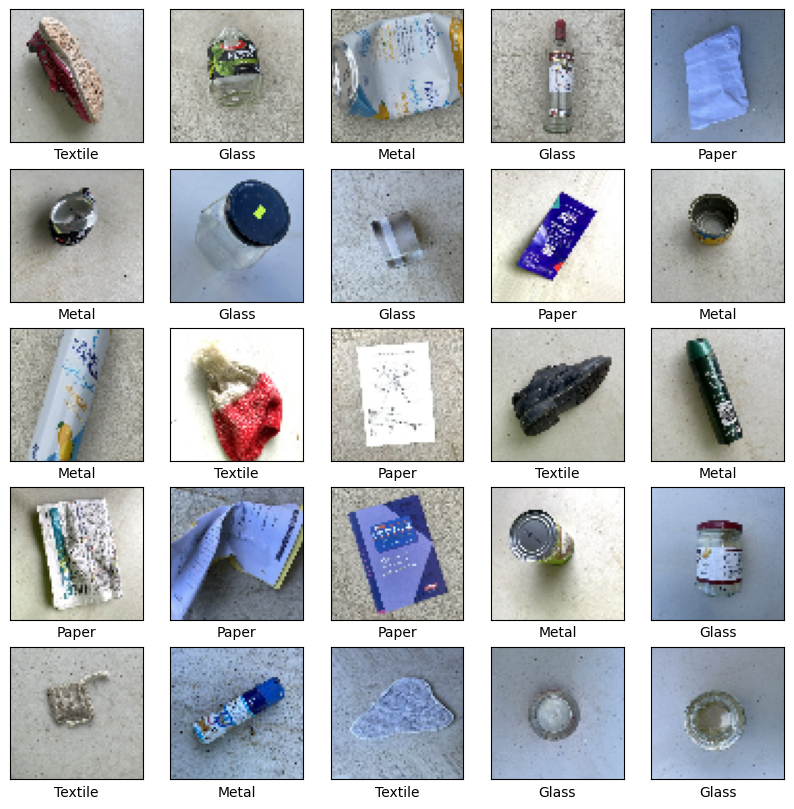

In [12]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
#Sequential Model 1 with 2 Convolutional layers
# Model was built based on tf.keras.layers - with different type of layers as shown below:
#Conv2D, BatchNormalization, Maxpooling, Dropout, Dense, Flatten, resizing


model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),                                                      
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,708 (2.08 MB)

 Trainable params: 544,516 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

## CNN custom Models 

In [14]:
#Sequential Model 2 with 4 Convolutional layers
# Model was built based on tf.keras.layers - with different type of layers as shown below:
#Conv2D, BatchNormalization, Maxpooling, Dropout, Dense, Flatten, resizing


model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 300,164 (1.15 MB)

 Trainable params: 299,460 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [15]:
#Sequential Model 3 with 5 Convolutional layers
# Model was built based on tf.keras.layers - with different type of layers as shown below:
#Conv2D, BatchNormalization, Maxpooling, Dropout, Dense, Flatten, resizing

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (2,2), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation ='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 193,444 (755.64 KB)

 Trainable params: 192,868 (753.39 KB)

 Non-trainable params: 576 (2.25 KB)

## Model checkpoint path for model 1 to 3 to monitor validation accuracy

In [16]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

## Compile model 1 to 3 with optimum learning rate.

In [17]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

## Setup learning rate scheduler

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [19]:
#Learning rate scheduler for Model 3

def scheduler2(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

## Define the number of epochs and batch size

In [20]:
# Set number of epochs
epochs = 150
batch_size = 64

## Model fitting with validation split 20%

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-11-16 19:58:18.838184

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4005 - loss: 16.8999
Epoch 1: val_accuracy improved from -inf to 0.39167, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.4053 - loss: 16.6826 - val_accuracy: 0.3917 - val_loss: 10.4207 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5896 - loss: 8.9556
Epoch 2: val_accuracy improved from 0.39167 to 0.46111, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5909 - loss: 8.8717 - val_accuracy: 0.4611 - val_loss: 6.3597 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/s


Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8715 - loss: 1.2868
Epoch 20: val_accuracy improved from 0.53611 to 0.62778, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8692 - loss: 1.2908 - val_accuracy: 0.6278 - val_loss: 1.9347 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8432 - loss: 1.3731
Epoch 21: val_accuracy did not improve from 0.62778
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8419 - loss: 1.3770 - val_accuracy: 0.4028 - val_loss: 2.4772 - learning_rate: 0.0015

Epoch 22: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 22/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8544 - loss: 1.3851
Epoch 22: val_accuracy did not improve from 0.62778
23/23


Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9344 - loss: 0.7930
Epoch 39: val_accuracy improved from 0.75833 to 0.76389, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9342 - loss: 0.7931 - val_accuracy: 0.7639 - val_loss: 1.2123 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9420 - loss: 0.7541
Epoch 40: val_accuracy improved from 0.76389 to 0.80556, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9408 - loss: 0.7559 - val_accuracy: 0.8056 - val_loss: 1.0747 - learning_rate: 9.4537e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0008981053746538237.
Epoch 41/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9555 - l


Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9960 - loss: 0.2357
Epoch 76: val_accuracy did not improve from 0.86389
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9959 - loss: 0.2360 - val_accuracy: 0.8389 - val_loss: 0.6161 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9951 - loss: 0.2361
Epoch 77: val_accuracy did not improve from 0.86389
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9947 - loss: 0.2364 - val_accuracy: 0.8556 - val_loss: 0.5763 - learning_rate: 1.4170e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0001346172415651381.
Epoch 78/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9925 - loss: 0.2363
Epoch 78: val_accuracy improved from 0.86389 to 0.87222, saving model to C:/Mani/ModelCheckpoint/model


Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9968 - loss: 0.2017
Epoch 95: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9969 - loss: 0.2017 - val_accuracy: 0.8611 - val_loss: 0.5653 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9980 - loss: 0.1965
Epoch 96: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9980 - loss: 0.1970 - val_accuracy: 0.8528 - val_loss: 0.5985 - learning_rate: 5.3472e-05

Epoch 97: LearningRateScheduler setting learning rate to 5.0798291340470314e-05.
Epoch 97/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9979 - loss: 0.1976
Epoch 97: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy


Epoch 114: LearningRateScheduler setting learning rate to 2.1239800207695226e-05.
Epoch 114/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9966 - loss: 0.1882
Epoch 114: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9967 - loss: 0.1880 - val_accuracy: 0.8583 - val_loss: 0.5430 - learning_rate: 2.1240e-05

Epoch 115: LearningRateScheduler setting learning rate to 2.017781080212444e-05.
Epoch 115/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9969 - loss: 0.1892
Epoch 115: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9969 - loss: 0.1892 - val_accuracy: 0.8611 - val_loss: 0.5443 - learning_rate: 2.0178e-05

Epoch 116: LearningRateScheduler setting learning rate to 1.9168920607626203e-05.
Epoch 116/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9987 - loss: 0.1901
Epoch 116: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step -


Epoch 133: LearningRateScheduler setting learning rate to 8.014915329113137e-06.
Epoch 133/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9991 - loss: 0.1813
Epoch 133: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9991 - loss: 0.1812 - val_accuracy: 0.8611 - val_loss: 0.5405 - learning_rate: 8.0149e-06

Epoch 134: LearningRateScheduler setting learning rate to 7.6141699082654665e-06.
Epoch 134/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9971 - loss: 0.1868
Epoch 134: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9970 - loss: 0.1867 - val_accuracy: 0.8583 - val_loss: 0.5441 - learning_rate: 7.6142e-06

Epoch 135: LearningRateScheduler setting learning rate to 7.233461542455188e-06.
Epoch 135/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9981 - loss: 0.1851
Epoch 135: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - 

In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-11-16 20:02:36.441603

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.3985 - loss: 6.0295
Epoch 1: val_accuracy improved from -inf to 0.24444, saving model to C:/Mani/ModelCheckpoint/model2.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.4008 - loss: 6.0199 - val_accuracy: 0.2444 - val_loss: 5.6260 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5563 - loss: 5.2786
Epoch 2: val_accuracy did not improve from 0.24444
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.5570 - loss: 5.2736 - val_accuracy: 0.2444 - val_loss: 5.7141 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6451 - loss: 4.7595
Epoch 3: val_a

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9755 - loss: 0.6079
Epoch 37: val_accuracy did not improve from 0.78056
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.9752 - loss: 0.6085 - val_accuracy: 0.7361 - val_loss: 1.3049 - learning_rate: 7.3509e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006983372120885178.
Epoch 38/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9711 - loss: 0.6029
Epoch 38: val_accuracy did not improve from 0.78056
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.9711 - loss: 0.6027 - val_accuracy: 0.7444 - val_loss: 1.1579 - learning_rate: 6.9834e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9738 - loss: 0.5721
Epoch 39: val_accuracy did not improve from 0.78056
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.9738 - loss: 0.5722 - val_accuracy: 0.7167 - val_loss: 1.2682 - learning_rate: 6.6342e

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.9963 - loss: 0.3196 - val_accuracy: 0.8778 - val_loss: 0.6663 - learning_rate: 2.9199e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.00027738953212974593.
Epoch 56/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9990 - loss: 0.3085
Epoch 56: val_accuracy did not improve from 0.87778
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.9989 - loss: 0.3085 - val_accuracy: 0.8528 - val_loss: 0.7650 - learning_rate: 2.7739e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9940 - loss: 0.3080
Epoch 57: val_accuracy did not improve from 0.87778
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.9941 - loss: 0.3077 - val_accuracy: 0.8639 - val_loss: 0.6733 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0

Epoch 74/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.2130
Epoch 74: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 1.0000 - loss: 0.2130 - val_accuracy: 0.8972 - val_loss: 0.5215 - learning_rate: 1.1018e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.00010467393149156123.
Epoch 75/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9997 - loss: 0.2114
Epoch 75: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.9997 - loss: 0.2114 - val_accuracy: 0.8833 - val_loss: 0.5430 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 1.0000 - loss: 0.2093
Epoch 76: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 1.0000 - loss: 0.2093 - val_accuracy: 0.8917 - val_loss: 0.5291 - learning

Epoch 93/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 1.0000 - loss: 0.1763
Epoch 93: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 1.0000 - loss: 0.1763 - val_accuracy: 0.8944 - val_loss: 0.5213 - learning_rate: 4.1578e-05

Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 1.0000 - loss: 0.1773
Epoch 94: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 1.0000 - loss: 0.1772 - val_accuracy: 0.8917 - val_loss: 0.5245 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 1.0000 - loss: 0.1761
Epoch 95: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 1.0000 - loss: 0.1761 - val_accuracy: 0.8861 - val_loss: 0.5246 - learning_


Epoch 112: LearningRateScheduler setting learning rate to 1.568960378790507e-05.
Epoch 112/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 1.0000 - loss: 0.1632
Epoch 112: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 1.0000 - loss: 0.1632 - val_accuracy: 0.8889 - val_loss: 0.5225 - learning_rate: 1.5690e-05

Epoch 113: LearningRateScheduler setting learning rate to 1.490512377131381e-05.
Epoch 113/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9993 - loss: 0.1634
Epoch 113: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.9993 - loss: 0.1634 - val_accuracy: 0.8889 - val_loss: 0.5223 - learning_rate: 1.4905e-05

Epoch 114: LearningRateScheduler setting learning rate to 1.4159867669150115e-05.
Epoch 114/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 1.0000 - loss: 0.1629
Epoch 114: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/s


Epoch 131: LearningRateScheduler setting learning rate to 5.920527905800554e-06.
Epoch 131/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 1.0000 - loss: 0.1575
Epoch 131: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 1.0000 - loss: 0.1575 - val_accuracy: 0.9000 - val_loss: 0.5108 - learning_rate: 5.9205e-06

Epoch 132: LearningRateScheduler setting learning rate to 5.624501704915019e-06.
Epoch 132/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 1.0000 - loss: 0.1564
Epoch 132: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - accuracy: 1.0000 - loss: 0.1564 - val_accuracy: 0.9000 - val_loss: 0.5090 - learning_rate: 5.6245e-06

Epoch 133: LearningRateScheduler setting learning rate to 5.343276598068769e-06.
Epoch 133/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 1.0000 - loss: 0.1579
Epoch 133: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/st


Epoch 150: LearningRateScheduler setting learning rate to 2.2341329326991397e-06.
Epoch 150/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 1.0000 - loss: 0.1545
Epoch 150: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 1.0000 - loss: 0.1545 - val_accuracy: 0.8972 - val_loss: 0.5089 - learning_rate: 2.2341e-06
Time model end: 2024-11-16 20:21:43.304003
Model_2_training_time 0:19:06.862400


In [23]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-16 20:21:43.309924

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.3257 - loss: 14.8400
Epoch 1: val_accuracy improved from -inf to 0.24444, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.3285 - loss: 14.8048 - val_accuracy: 0.2444 - val_loss: 12.7573 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5009 - loss: 11.8351
Epoch 2: val_accuracy did not improve from 0.24444
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.5009 - loss: 11.8111 - val_accuracy: 0.2444 - val_loss: 10.9972 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5292 - loss: 9.4191



Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8559 - loss: 1.0640
Epoch 20: val_accuracy improved from 0.24444 to 0.24722, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.8556 - loss: 1.0640 - val_accuracy: 0.2472 - val_loss: 3.6228 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8593 - loss: 1.0161
Epoch 21: val_accuracy improved from 0.24722 to 0.35278, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.8594 - loss: 1.0161 - val_accuracy: 0.3528 - val_loss: 2.3217 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 22/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.841

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8937 - loss: 0.9120
Epoch 38: val_accuracy did not improve from 0.73056
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.8929 - loss: 0.9142 - val_accuracy: 0.4500 - val_loss: 2.3159 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8815 - loss: 0.9527
Epoch 39: val_accuracy did not improve from 0.73056
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.8815 - loss: 0.9526 - val_accuracy: 0.3694 - val_loss: 2.9550 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8978 - loss: 0.9030
Epoch 40: val_accuracy did not improve from 0.73056
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.8974 - loss: 0.9035 - val_accuracy: 0.5056 - val_loss: 2.0066 - learning_rate: 9.8000e


Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9556 - loss: 0.5945
Epoch 57: val_accuracy did not improve from 0.76389
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.9551 - loss: 0.5951 - val_accuracy: 0.6944 - val_loss: 1.3099 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9478 - loss: 0.5973
Epoch 58: val_accuracy did not improve from 0.76389
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.9475 - loss: 0.5974 - val_accuracy: 0.4056 - val_loss: 2.4955 - learning_rate: 5.2955e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0005030752246966585.
Epoch 59/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9512 - loss: 0.5891
Epoch 59: val_accuracy did not improve from 0.76389
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accur


Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9945 - loss: 0.2272
Epoch 94: val_accuracy did not improve from 0.90833
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.9946 - loss: 0.2269 - val_accuracy: 0.8917 - val_loss: 0.5438 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9973 - loss: 0.2149
Epoch 95: val_accuracy improved from 0.90833 to 0.91389, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.9973 - loss: 0.2150 - val_accuracy: 0.9139 - val_loss: 0.4904 - learning_rate: 7.9375e-05

Epoch 96: LearningRateScheduler setting learning rate to 7.540605693066026e-05.
Epoch 96/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9931 - loss: 0.2180
Epoch 96: val_accuracy did not improve fr

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.9972 - loss: 0.1814 - val_accuracy: 0.9028 - val_loss: 0.4626 - learning_rate: 3.3188e-05

Epoch 113: LearningRateScheduler setting learning rate to 3.1528807448921724e-05.
Epoch 113/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9986 - loss: 0.1770
Epoch 113: val_accuracy did not improve from 0.91667
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.9986 - loss: 0.1770 - val_accuracy: 0.9000 - val_loss: 0.4711 - learning_rate: 3.1529e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.9952368458907584e-05.
Epoch 114/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9987 - loss: 0.1781
Epoch 114: val_accuracy did not improve from 0.91667
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.9987 - loss: 0.1781 - val_accuracy: 0.9083 - val_loss: 0.4575 - learning_rate: 2.9952e-05

Epoch 115: LearningRateScheduler setting learning rate to 2.8454750554374184e-05.
Epoch 115/150
23/23 ━━━━━━━━━━━━

Epoch 131/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 1.0000 - loss: 0.1638
Epoch 131: val_accuracy did not improve from 0.92222
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 1.0000 - loss: 0.1638 - val_accuracy: 0.9222 - val_loss: 0.4227 - learning_rate: 1.2524e-05

Epoch 132: LearningRateScheduler setting learning rate to 1.1897510012204293e-05.
Epoch 132/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9985 - loss: 0.1652
Epoch 132: val_accuracy did not improve from 0.92222
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.9985 - loss: 0.1652 - val_accuracy: 0.9139 - val_loss: 0.4233 - learning_rate: 1.1898e-05

Epoch 133: LearningRateScheduler setting learning rate to 1.1302634857202064e-05.
Epoch 133/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9995 - loss: 0.1640
Epoch 133: val_accuracy did not improve from 0.92222
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.9994 - loss: 0.1640 - val_accuracy: 0.9139 - val_loss: 0.4306 -


Epoch 150: LearningRateScheduler setting learning rate to 4.725861754195648e-06.
Epoch 150/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.1600
Epoch 150: val_accuracy did not improve from 0.92222
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 1.0000 - loss: 0.1599 - val_accuracy: 0.9083 - val_loss: 0.4245 - learning_rate: 4.7259e-06
Time model end: 2024-11-16 20:39:43.657757
Model_3_training_time 0:18:00.347833


## Plot accuracy and loss against epochs during training and validation

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:6.2)')

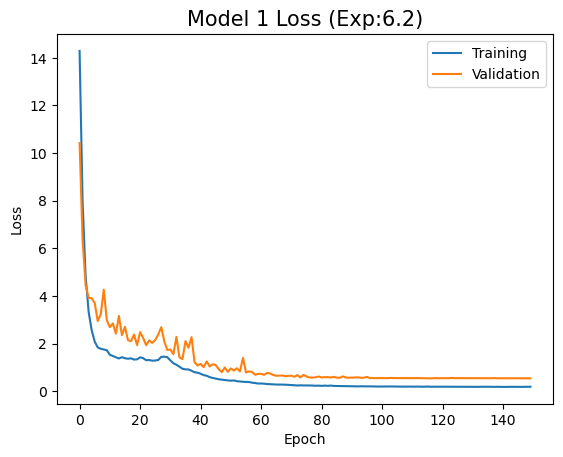

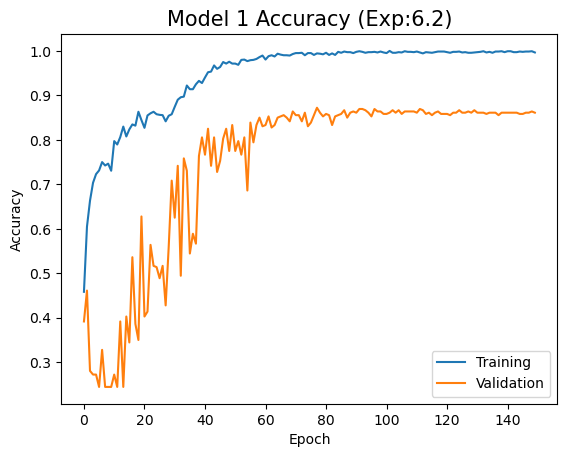

In [24]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:6.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:6.2)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:6.2)')

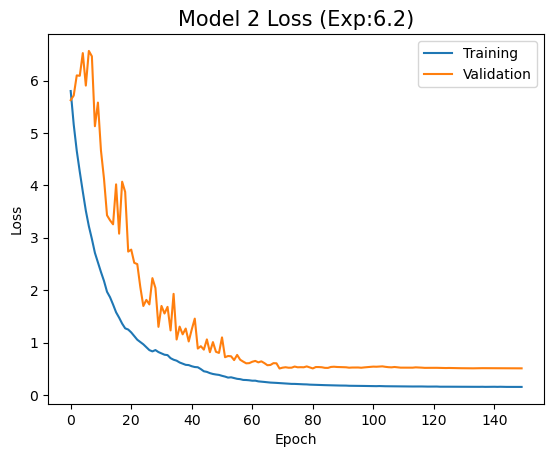

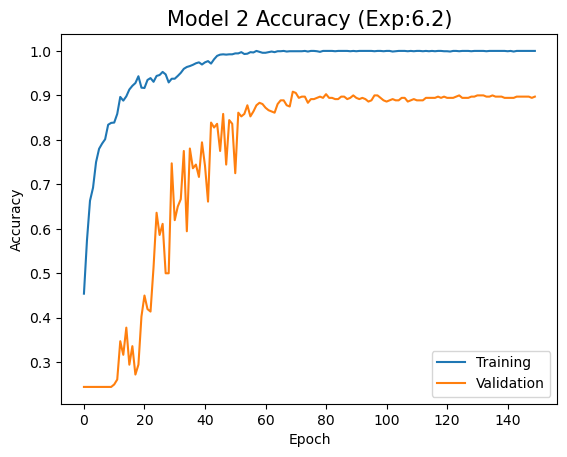

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:6.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:6.2)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:6.2)')

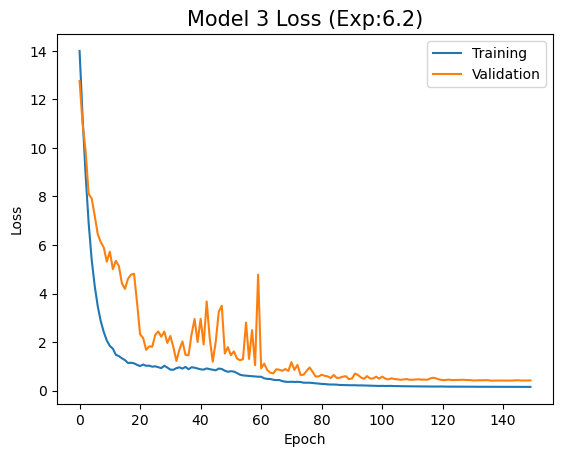

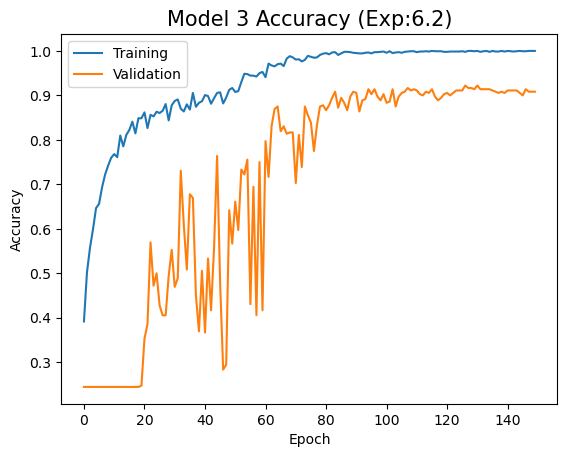

In [26]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:6.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:6.2)', fontsize = 15)

## Evaluate the model for test images

In [27]:
# Evaluate the test result for model 1, 2, 3
#model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

#model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

#model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9647 - loss: 0.3528
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9446 - loss: 0.3161
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9631 - loss: 0.2674


## Confusion matrix for model 1 to 3

In [28]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


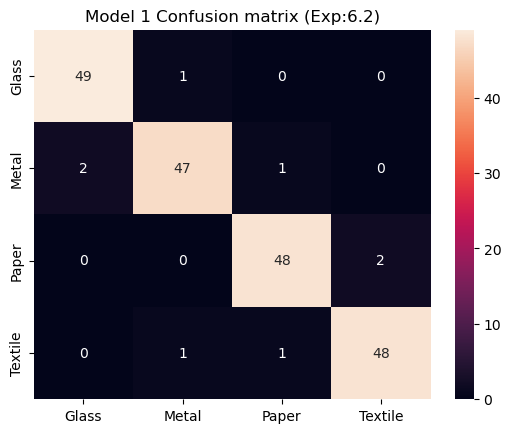

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:6.2)')
plt.show()

In [30]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


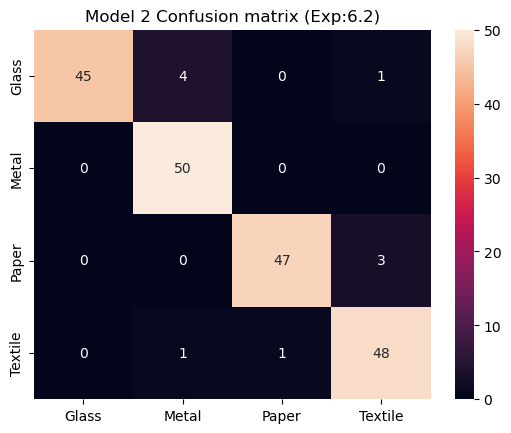

In [31]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:6.2)')
plt.show()

In [32]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


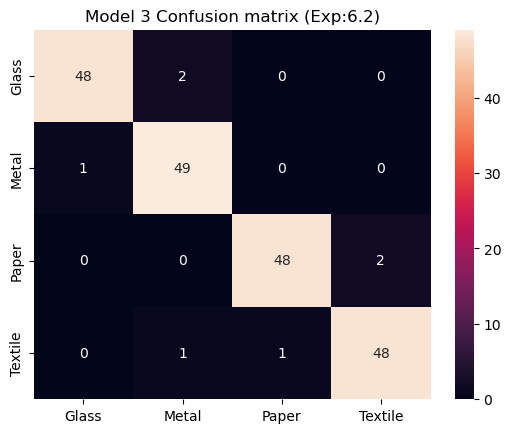

In [33]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:6.2)')
plt.show()

## Display 25 images for each model with actual and predicted label

25 random image with actual and predicted label for Model 1


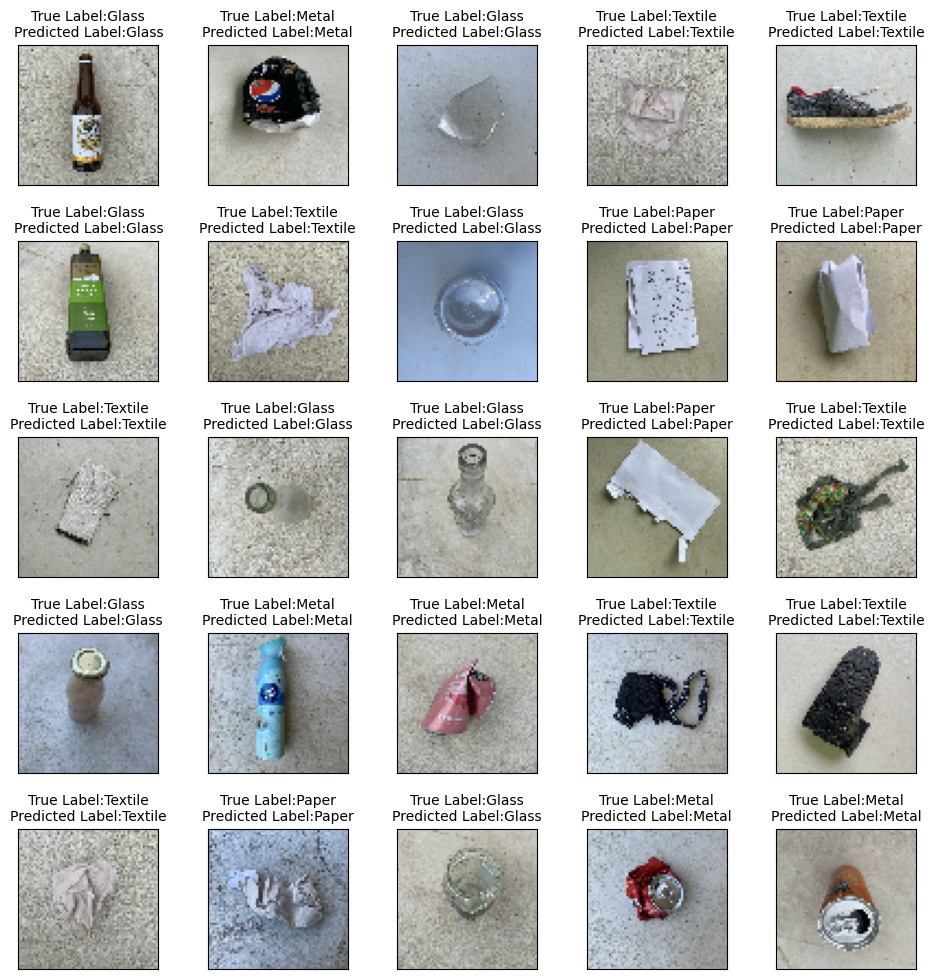

In [34]:
#Display actual and predicted labels for 25 images model 3
print('25 random image with actual and predicted label for Model 1')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label1[i]], fontsize = 10)
    
    
    #plt.show()

25 random image with actual and predicted label for Model 2


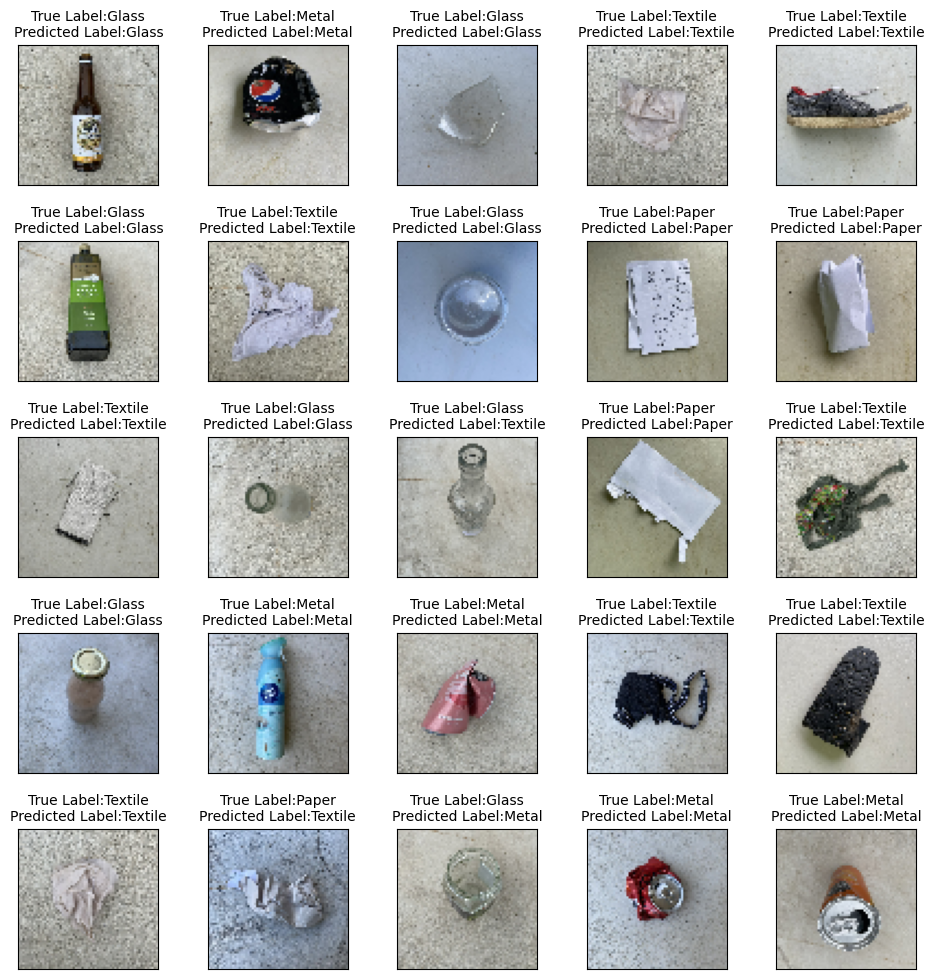

In [35]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 2')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label2[i]], fontsize = 10)
    

25 random image with actual and predicted label for Model 3


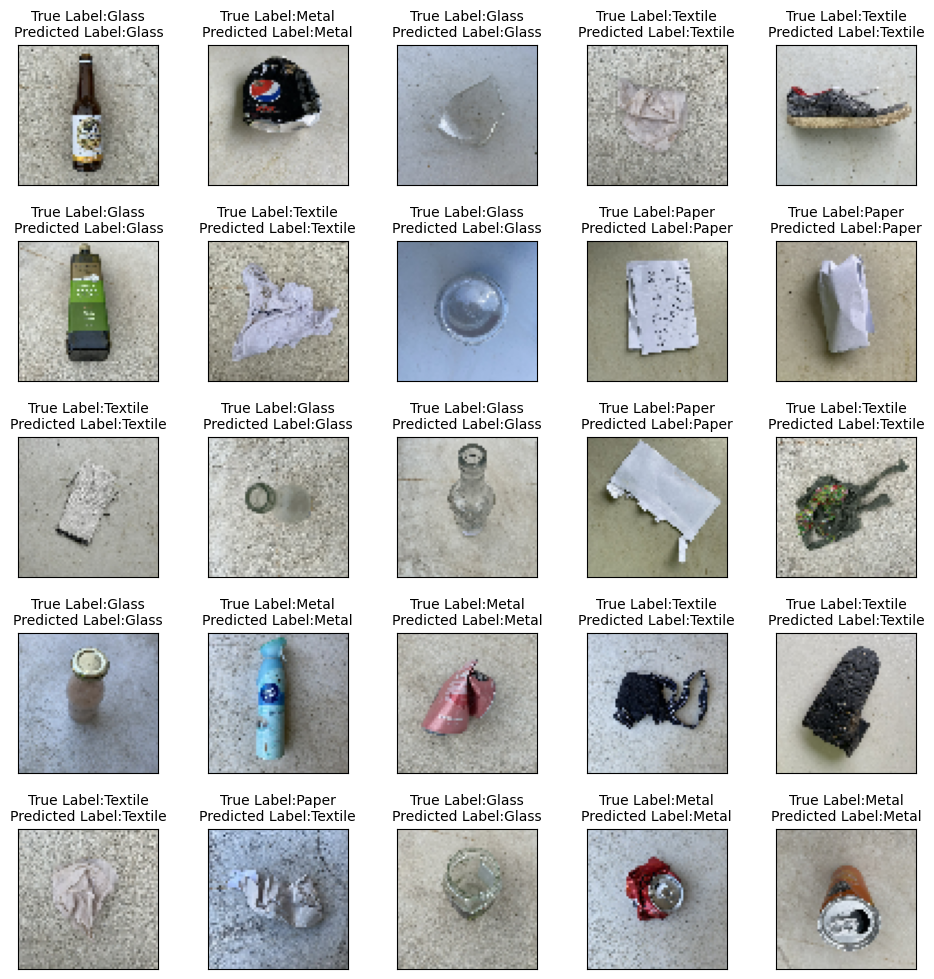

In [36]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 3')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label3[i]], fontsize = 10)
    

## Display the misclassied image for model 1 to 3

In [44]:
def display_mislabel_images(class_names, images, labels):
    """
        Display mislabel images from the images array with its corresponding labels
    """
  
    fig = plt.figure(figsize=(15,15))
    #fig.suptitle("mislabeled images", fontsize=16)
    for i in range(7):
        plt.subplot(4,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]], fontsize = 15) 
    plt.show()

In [38]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print all the mislabeled images by the classifier
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
         
    display_mislabel_images(class_names,  mislabeled_images, mislabeled_labels)

Mislabel image for model 1


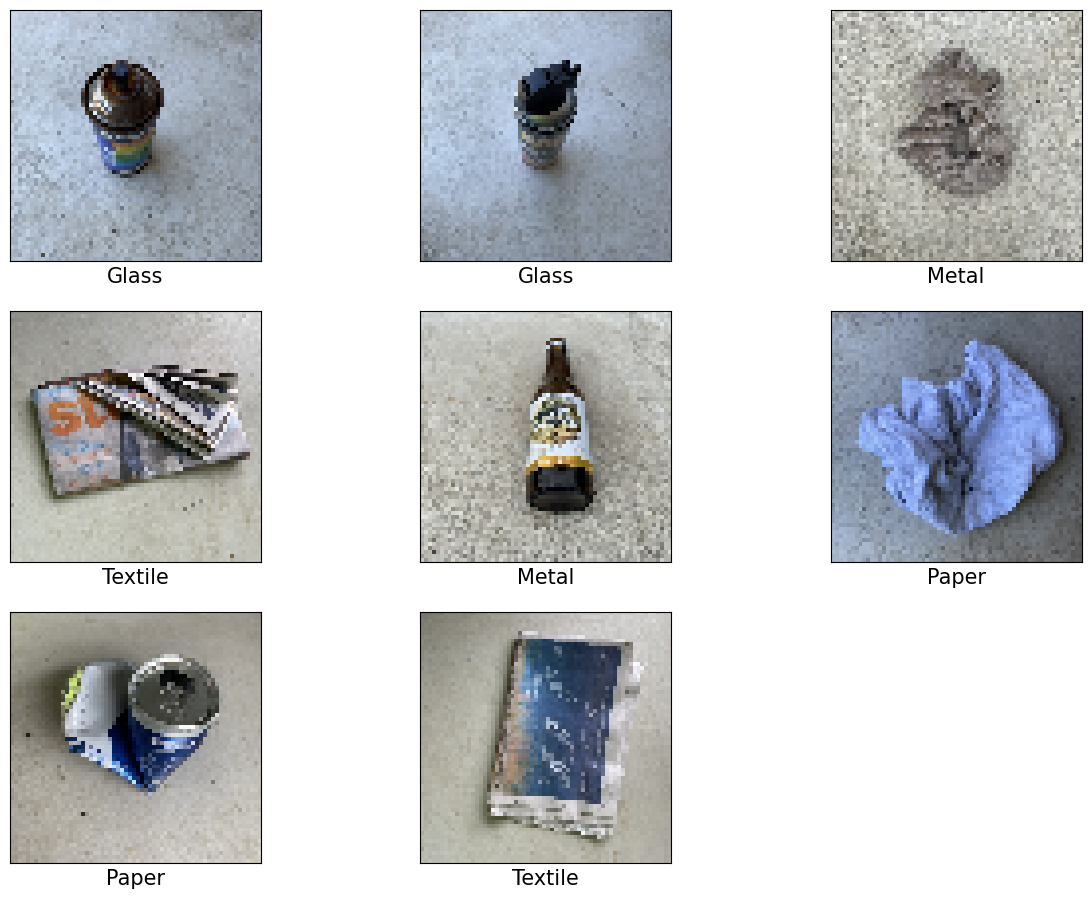

In [41]:
print('Mislabel image for model 1')
print_mislabeled_images(class_names, test_images, test_labels, pred_label1)

Mislabel image for model 2


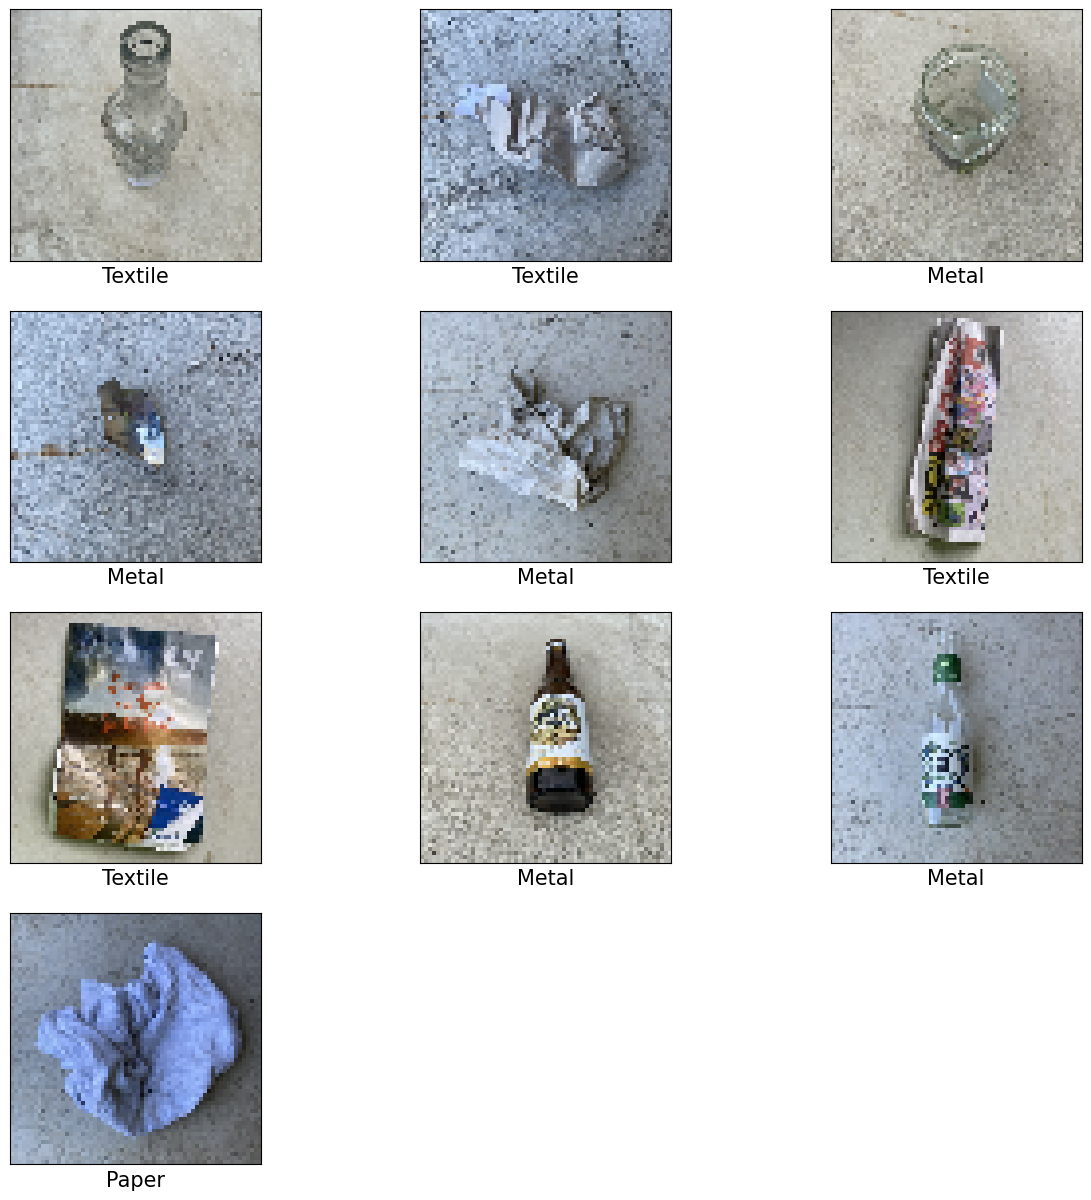

In [43]:
print('Mislabel image for model 2')
print_mislabeled_images(class_names, test_images, test_labels, pred_label2)

Mislabel image for model 3


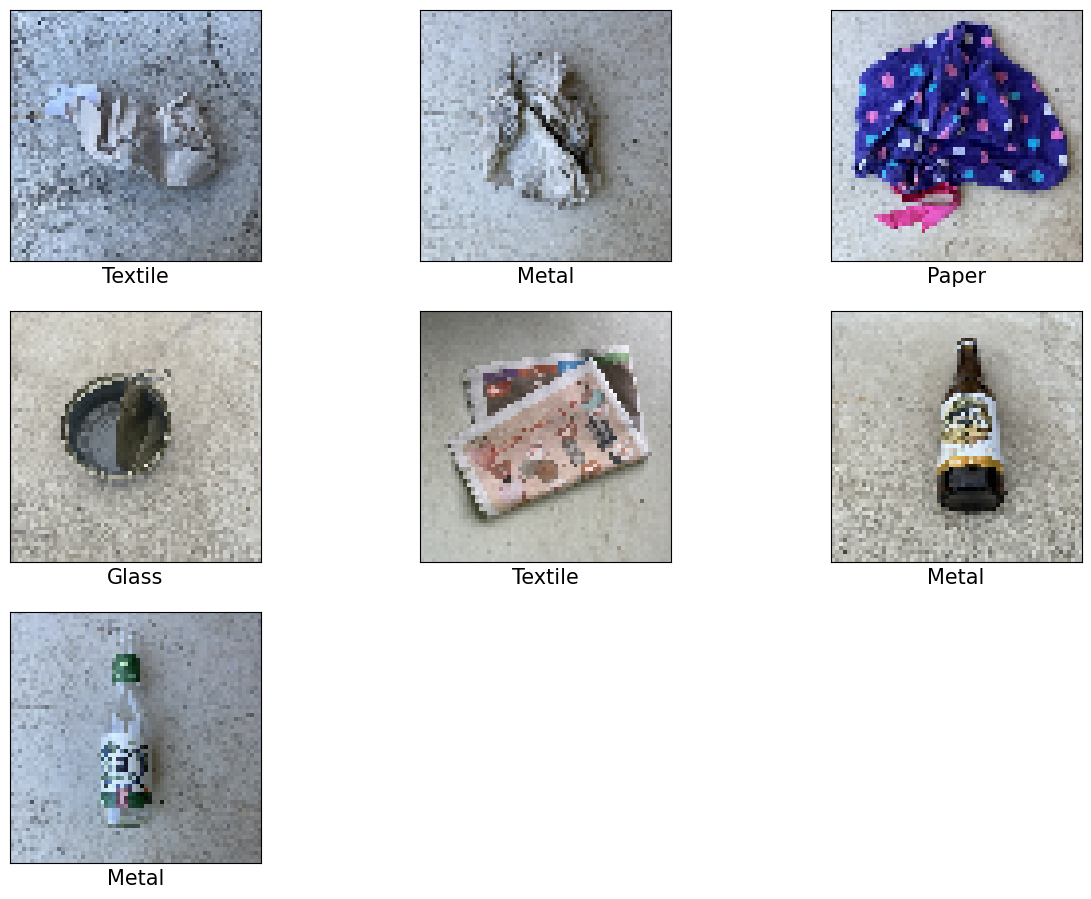

In [45]:
print('Mislabel image for model 3')
print_mislabeled_images(class_names, test_images, test_labels, pred_label3)

## Predict a single image

Predict start: 2024-11-16 20:46:56.329455


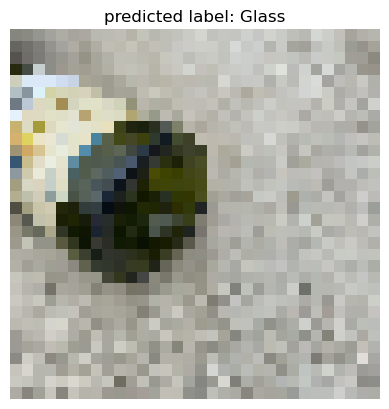

Predict end: 2024-11-16 20:46:56.434633
Prediction time: 0:00:00.105178


In [46]:
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (32, 32)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_2.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_1(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-11-16 20:47:26.106812


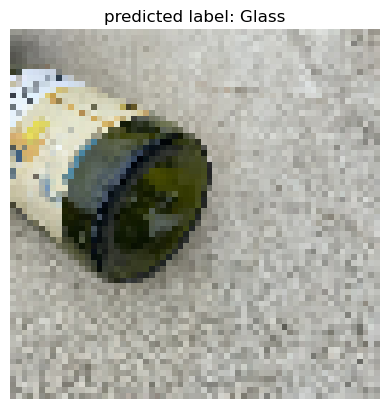

Predict end: 2024-11-16 20:47:26.205651
Prediction time: 0:00:00.098839


In [49]:
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_2.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_2(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-11-16 20:47:35.493020


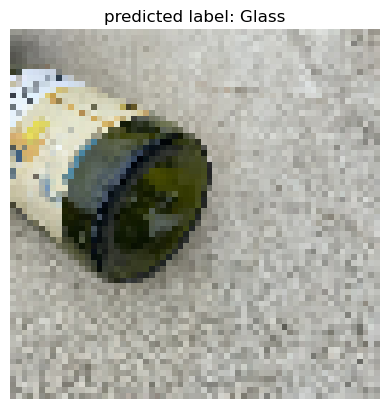

Predict end: 2024-11-16 20:47:35.589646
Prediction time: 0:00:00.096626


In [50]:
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_2.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_3(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

## Pre-Training model - Transfer Learning

In [51]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (224, 224)

In [52]:
#Prepare dataset for training and testing for Pre-train Model
(train_images1, train_labels1), (test_images1, test_labels1) = load_data(train_ds_2, test_ds_2)

Loading C:/Mani/Dataset/dataset2/train_ds


100%|████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 258.58it/s]


Loading C:/Mani/Dataset/dataset2/test_ds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 211.19it/s]


In [53]:
# Shuffle only the training dataset
np.random.seed(321)
train_images1, train_labels1 = shuffle(train_images1, train_labels1)
test_images1, test_labels1 = shuffle(test_images1, test_labels1)

In [54]:
#Check the training and testing image shape - should 224 by 224 for Resnet50
train_images1.shape, test_images1.shape

((1800, 224, 224, 3), (200, 224, 224, 3))

In [55]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath4 = 'C:/Mani/ModelCheckpoint/model4.keras'
model_checkpoint_callback4 = ModelCheckpoint(
    filepath=checkpoint_filepath4,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath5 = 'C:/Mani/ModelCheckpoint/model5.keras'
model_checkpoint_callback5 = ModelCheckpoint(
    filepath=checkpoint_filepath5,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)



## Pre-Trained Model - EfficientNetV2L

In [56]:
#EfficientNet pre-trained model
base_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights='imagenet',
    input_shape=((224,224,3)),
    )


In [57]:
base_model.trainable = False

In [58]:
# Build EfficientNetV2 model for waste classification

model_EfficientNetV2 = tf.keras.Sequential([
    tf.keras.layers.Input((224,224,3)),
    base_model,
    tf.keras.layers.Conv2D(32, (3,3),padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_EfficientNetV2.summary()    


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,153,028 (450.72 MB)

 Trainable params: 406,180 (1.55 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [59]:
#Compile Efficientnet model

base_learning_rate = 0.0003
model_EfficientNetV2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])



## Fit EfficientNet 

In [60]:
E_epochs = 40
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)

history4 = model_EfficientNetV2.fit(train_images1, train_labels1,
                       batch_size=batch_size, epochs= E_epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback4
                                 ])

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time) 

Time model start: 2024-11-16 20:51:03.102488
Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5683 - loss: 106.5928 
Epoch 1: val_accuracy improved from -inf to 0.88333, saving model to C:/Mani/ModelCheckpoint/model4.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 391s 16s/step - accuracy: 0.5745 - loss: 106.4133 - val_accuracy: 0.8833 - val_loss: 92.7832
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8959 - loss: 89.0182 
Epoch 2: val_accuracy improved from 0.88333 to 0.92222, saving model to C:/Mani/ModelCheckpoint/model4.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 344s 15s/step - accuracy: 0.8961 - loss: 88.8719 - val_accuracy: 0.9222 - val_loss: 77.5528
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9199 - loss: 74.3571 
Epoch 3: val_accuracy improved from 0.92222 to 0.93333, saving model to C:/Mani/ModelCheckpoint/model4.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 340s 15s/step - accuracy: 0.9202 - loss: 74.2323 - val_accuracy: 0.9333 - val_loss: 64.6578
Epoch 4/40
23/

Epoch 25/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9783 - loss: 0.7672 
Epoch 25: val_accuracy did not improve from 0.96944
23/23 ━━━━━━━━━━━━━━━━━━━━ 334s 15s/step - accuracy: 0.9782 - loss: 0.7658 - val_accuracy: 0.9500 - val_loss: 0.7137
Epoch 26/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9799 - loss: 0.6278 
Epoch 26: val_accuracy did not improve from 0.96944
23/23 ━━━━━━━━━━━━━━━━━━━━ 331s 14s/step - accuracy: 0.9796 - loss: 0.6271 - val_accuracy: 0.9528 - val_loss: 0.6041
Epoch 27/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9675 - loss: 0.5501 
Epoch 27: val_accuracy did not improve from 0.96944
23/23 ━━━━━━━━━━━━━━━━━━━━ 434s 19s/step - accuracy: 0.9677 - loss: 0.5492 - val_accuracy: 0.9667 - val_loss: 0.5199
Epoch 28/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9767 - loss: 0.4750 
Epoch 28: val_accuracy did not improve from 0.96944
23/23 ━━━━━━━━━━━━━━━━━━━━ 423s 19s/step - accuracy: 0.9767 - loss: 0.4744 - val_accuracy: 0.9639

Text(0.5, 1.0, 'EfficientNet Model Accuracy (Exp:6.2)')

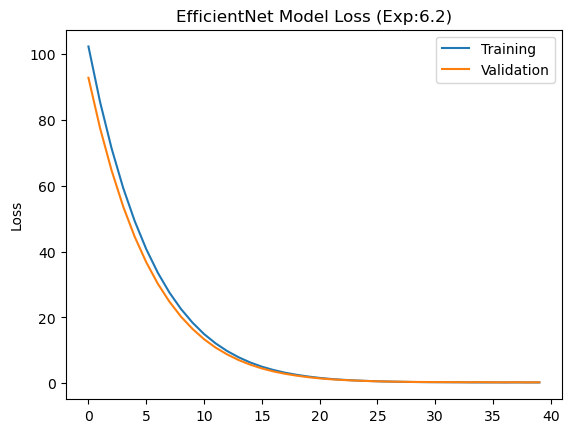

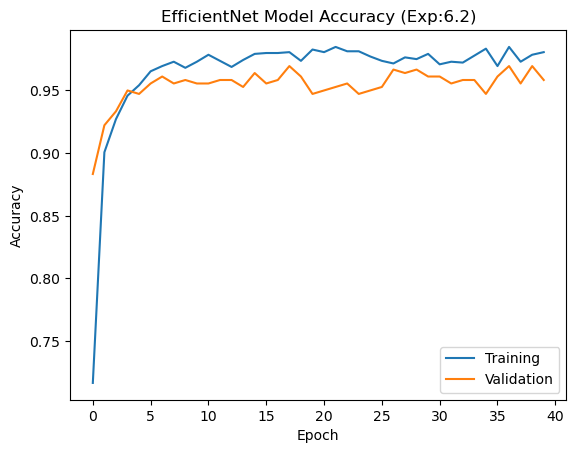

In [61]:

#Plot the training and validation loss
plt.figure()
plt.plot(history4.history['loss'], label='Training')
plt.plot(history4.history['val_loss'], label='Validation')
plt.legend(loc=0)

plt.ylabel('Loss')
plt.title('EfficientNet Model Loss (Exp:6.2)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history4.history['accuracy'], label='Training')
plt.plot(history4.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet Model Accuracy (Exp:6.2)')

In [91]:
#Load the best model1 weight from checkpoint
# Evaluate the test result EfficientNet

model_EfficientNetV2.load_weights(checkpoint_filepath4)
Test_result4 = model_EfficientNetV2.evaluate(test_images1, test_labels1, batch_size = 64)

4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.9646 - loss: 2.8894


In [92]:
# Reference tf.keras.applications.EffificentNetV2L - tensorflow > API > Tensorflow v2.16.1 > Python
#Load the best model1 weight from checkpoint
#model_EfficientNetV2.load_weights(checkpoint_filepath4)

#Obtain the model's prediction for the test_images
prediction4 = model_EfficientNetV2.predict(test_images1)

pred_label4 = np.argmax(prediction4, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step


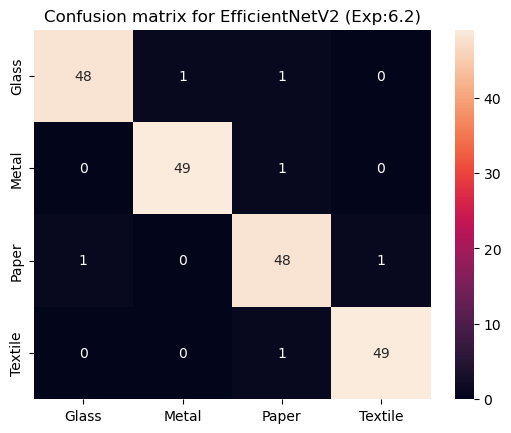

In [93]:
CM4 = confusion_matrix(test_labels1, pred_label4)
ax = plt.axes()
sns.heatmap(CM4, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix for EfficientNetV2 (Exp:6.2)')
plt.show()


## Pre-Train model - MobileNetV3Large

In [65]:
#base_model_MobileNetV3Large

base_model_MobileNetV3 = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=((224,224,3)),
    )

base_model_MobileNetV3.trainable = False

# Build MobileNetV3 model for waste classification

model_MobileNetV3 = tf.keras.Sequential([
    tf.keras.layers.Input((224,224,3)),
    base_model_MobileNetV3,
    tf.keras.layers.Conv2D(128, (3,3),padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layer.GlobalMaxPool2D((2,2))
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.6), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_MobileNetV3.summary()  

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 7, 7, 128)           │       1,106,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,251,012 (16.22 MB)

 Trainable params: 1,254,404 (4.79 MB)

 Non-trainable params: 2,996,608 (11.43 MB)

In [66]:
#Compile and fit MobileNet model

Mobile_learning_rate = 0.0002
M_epochs = 40

model_MobileNetV3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = Mobile_learning_rate),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


# Get the current time
start_time = datetime.now()
print('Time training start:', start_time)

history5 = model_MobileNetV3.fit(train_images1, train_labels1,
                       batch_size=batch_size, epochs= M_epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback5])

# Get the current time
end_time = datetime.now()
print('Time training end:', end_time)


Time training start: 2024-11-17 00:43:29.738862
Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.4892 - loss: 144.3812
Epoch 1: val_accuracy improved from -inf to 0.84167, saving model to C:/Mani/ModelCheckpoint/model5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4953 - loss: 144.1208 - val_accuracy: 0.8417 - val_loss: 124.4929
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8784 - loss: 118.8125
Epoch 2: val_accuracy improved from 0.84167 to 0.89444, saving model to C:/Mani/ModelCheckpoint/model5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8790 - loss: 118.5981 - val_accuracy: 0.8944 - val_loss: 102.2088
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.9399 - loss: 97.3906
Epoch 3: val_accuracy improved from 0.89444 to 0.91667, saving model to C:/Mani/ModelCheckpoint/model5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9400 - loss: 97.2090 - val_accuracy: 0.9167 - val_loss: 83.4020
Epoch 4/40

Text(0.5, 1.0, 'MobileNet Model Accuracy (Exp:6.2)')

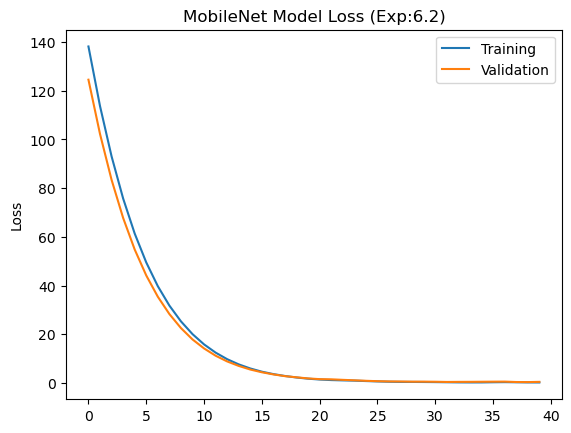

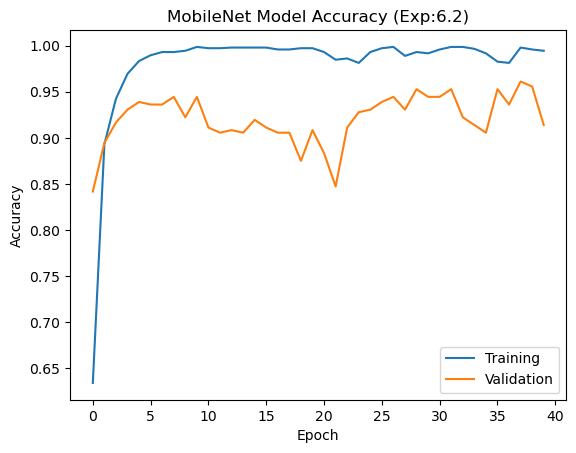

In [67]:
#Plot the training and validation loss
plt.figure()
plt.plot(history5.history['loss'], label='Training')
plt.plot(history5.history['val_loss'], label='Validation')
plt.legend(loc=0)

plt.ylabel('Loss')
plt.title('MobileNet Model Loss (Exp:6.2)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history5.history['accuracy'], label='Training')
plt.plot(history5.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MobileNet Model Accuracy (Exp:6.2)')

In [86]:
#Load the best mobileNetV3 weight from checkpoint_filepath5
model_MobileNetV3.load_weights(checkpoint_filepath5)
MobileNetV3_result = model_MobileNetV3.evaluate(test_images1, test_labels1)

print('MobileNetV3 accuracy:', MobileNetV3_result)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.9485 - loss: 0.3402
MobileNetV3 accuracy: [0.33505791425704956, 0.9649999737739563]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step


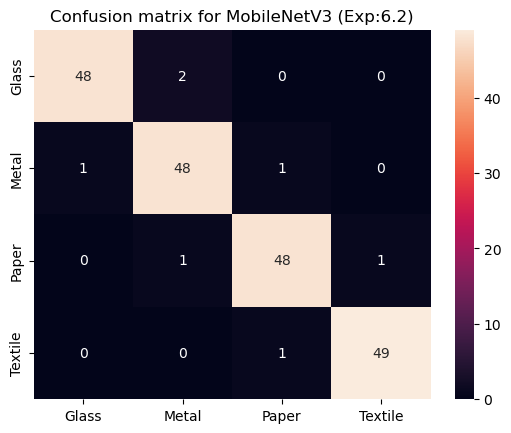

In [87]:
# Reference tf.keras.applications.MobileNetV3 - tensorflow > API > Tensorflow v2.16.1 > Python
#Load the best model weight from checkpoint
#model_MobileNetV3.load_weights(checkpoint_filepath5)

#Obtain the model's prediction for the test_images
prediction5 = model_MobileNetV3.predict(test_images1)

pred_label5 = np.argmax(prediction5, axis = 1)

CM5 = confusion_matrix(test_labels1, pred_label5)
ax = plt.axes()
sns.heatmap(CM5, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix for MobileNetV3 (Exp:6.2)')
plt.show()


In [94]:
def display_mislabel_images(class_names, images, labels):
    """
        Display mislabel images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("mislabeled images", fontsize=16)
    for i in range(6):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i]/255., cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]], fontsize = 15)
        
    plt.show()

In [71]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print all the mislabeled images by the classifier
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    actual_label = test_labels[mislabeled_indices]

      
    display_mislabel_images(class_names,  mislabeled_images, mislabeled_labels)

EfficientNetV2


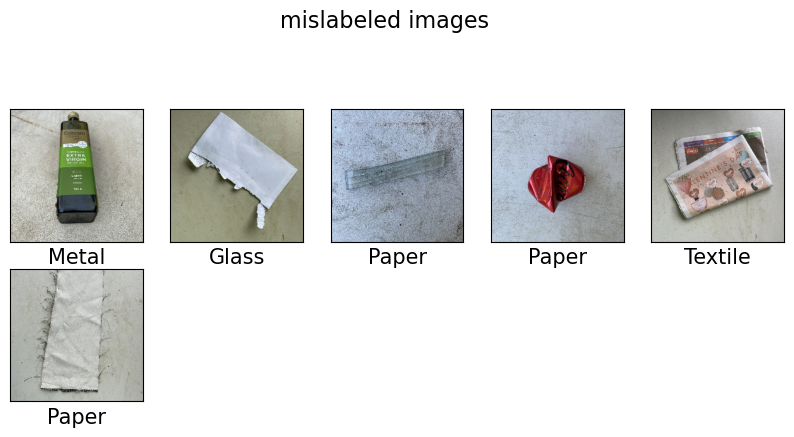

In [95]:
print('EfficientNetV2')
print_mislabeled_images(class_names, test_images1, test_labels1, pred_label4)

MobileNetV3


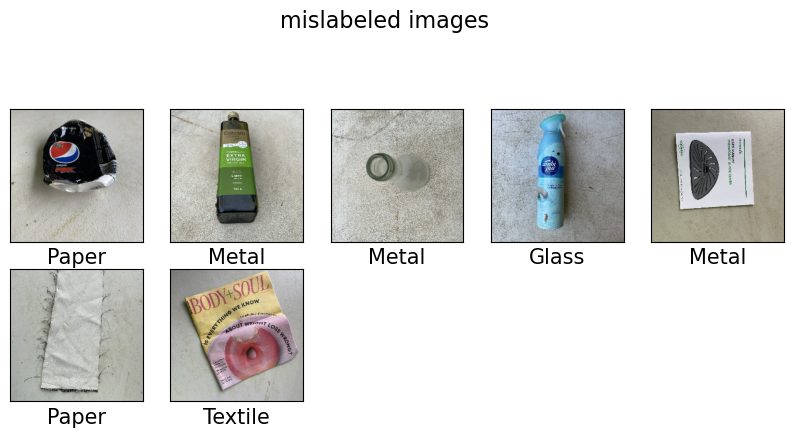

In [89]:
print('MobileNetV3')
print_mislabeled_images(class_names, test_images1, test_labels1, pred_label5)

## Predict Single images for mobileNet and EfficientNet

Time training start: 2024-11-17 07:24:17.575179


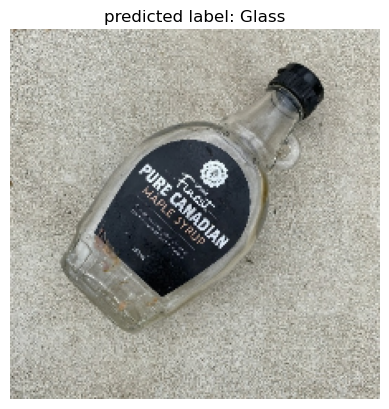

Time training end: 2024-11-17 07:24:18.045901
Prediction time: 0:00:00.470722


In [85]:
start_time = datetime.now()
print('Time training start:', start_time)

IMAGE_SIZE = (224, 224)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_6.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_MobileNetV3(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Time training end:', end_time)
print('Prediction time:', end_time - start_time)

Time training start: 2024-11-17 11:36:55.318683


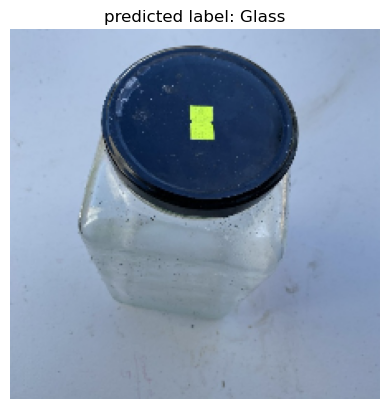

Time training end: 2024-11-17 11:36:57.401375
Prediction time: 0:00:02.082692


In [97]:
start_time = datetime.now()
print('Time training start:', start_time)

IMAGE_SIZE = (224, 224)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_82.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_EfficientNetV2(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Time training end:', end_time)
print('Prediction time:', end_time - start_time)